In [ ]:
import tensorflow as tf
import numpy as np
from skimage import io
import cv2
import os
import PIL
import tensorflow_datasets as tfds

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
#google drive 연동

drive.mount('/content/gdrive/')
path = 'gdrive/MyDrive/.kaggle/train'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# train_path = 'gdrive/MyDrive/.kaggle/train'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(32, 32),
  color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [ ]:
# test_path = 'gdrive/MyDrive/.kaggle/test'

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(32, 32),
  color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [ ]:
class_names = train_ds.class_names;
class_names

#class별 파일개수 count는 어떻게 하나요? 이전에는 아래와 같이 데이터프레임을 만들었습니다

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch)
  break

(32, 32, 32, 1)
tf.Tensor([2 5 5 4 0 5 5 0 3 2 6 5 6 0 3 3 1 0 2 6 5 0 3 4 0 2 6 5 2 4 6 5], shape=(32,), dtype=int32)


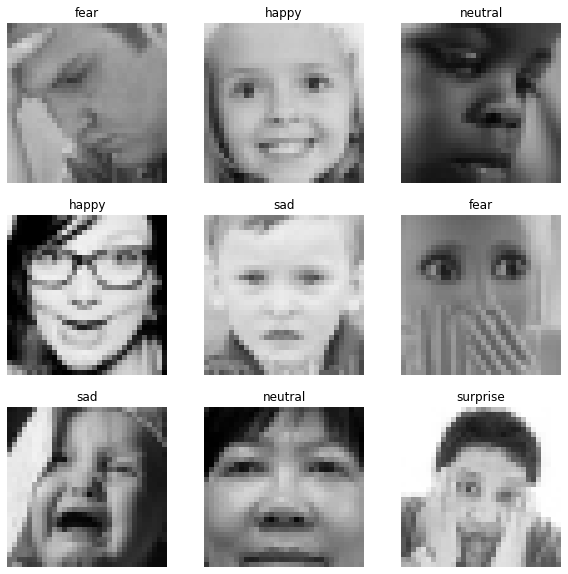

In [ ]:
#컬러를 grayscale로 바꾸었더니, 여기서 계속 에러가 납니다. 뭘 바꿔줘야 할지 모르겠어요ㅠ

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")[:,:,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.015441177 0.97647065
0.033578433 0.9867648


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32, 1)))
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  train_ds,
  batch_size=32,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
718/718 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1406 - val_loss: nan - val_accuracy: 0.1333
Epoch 2/10
718/718 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1406 - val_loss: nan - val_accuracy: 0.1333
Epoch 3/10
718/718 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1406 - val_loss: nan - val_accuracy: 0.1333
Epoch 4/10
718/718 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1406 - val_loss: nan - val_accuracy: 0.1333
Epoch 5/10
718/718 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1406 - val_loss: nan - val_accuracy: 0.1333
Epoch 6/10
718/718 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.1406 - val_loss: nan - val_accuracy: 0.1333
Epoch 7/10
718/718 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.1406 - val_loss: nan - val_accuracy: 0.1333
Epoch 8/10
718/718 [============================

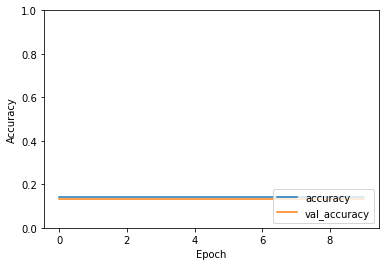

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

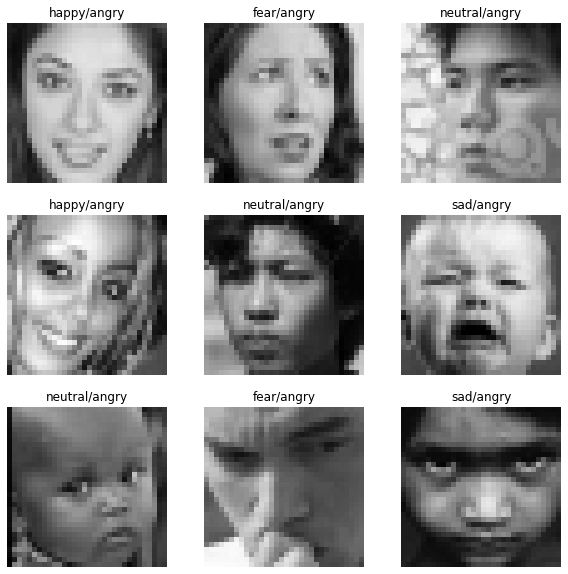

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")[:,:,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    a = (model.predict(images))
    plt.title(class_names[labels[i]] + '/' + class_names[tf.argmax(a[i])])
    plt.axis("off")

In [ ]:
#data generation을 할때 위에서 색상 변경 해주었어도 다시 color_mode 지정 해주어야 하나요?

train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255.,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )

NameError: ignored

In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1./255.,
                                         validation_split = 0.2)

validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 1432 images belonging to 7 classes.
